In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...
from scipy.stats.mstats import gmean

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

https://www.imf.org/external/np/sta/tegppi/ch20.pdf

This .pdf plug in the different chapters gives a good idea about stuff. 20 talks about elemetry indicies, so say do that at a low level, then when you aggregate do something like a tornqvist of fisher

I'm going to follow Broda and Weinstein (2006) https://web.stanford.edu/~klenow/Broda_and_Weinstein.pdf in setting things up.

The first question is level of aggregation and what a variety is. I'm going to do this at the HS4 level. What this means is then each HS10 product X country within the HS4 code is a variety. 

In [2]:
def make_expenditure_shares(df):
    
    df["S_gct"] = df["CON_VAL_MO"] / df["CON_VAL_MO"].sum()
    
    df["log_S_gct"] = np.nan
    
    df["log_S_gct"][df["CON_VAL_MO"]>0] = np.log( df["S_gct"][df["CON_VAL_MO"]>0] )
     
    return df

In [4]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

In [991]:
end_use = "hs?get=CTY_NAME,CON_VAL_MO,CAL_DUT_MO,I_COMMODITY,I_COMMODITY_SDESC"

surl = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 

surl  = surl + my_key + "&time==from+2013-01" + "&COMM_LVL=HS4" 

r = requests.get(surl)

print(r)

df = pd.DataFrame(r.json()[1:])

df.columns = r.json()[0]

<Response [200]>


In [1014]:
hs4_list[900]

'2840'

In [988]:
hs4_list = list(df.I_COMMODITY.unique())

In [1015]:
end_use = "hs?get=CON_VAL_MO,CTY_NAME,I_COMMODITY_SDESC,CON_QY1_MO,UNIT_QY1,SUMMARY_LVL"

url = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 
url = url + my_key + "&time==from+2013-01" + "&COMM_LVL=HS10" + "&I_COMMODITY=2804*" + "&CTY_CODE=*"

In [1016]:
df = pd.DataFrame()
    
temp_url = url 
    
r = requests.get(temp_url)

print(xxx)

print(r)
    
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
    # Note that the first entry is the labels
    
df.columns = r.json()[0]

df.time = pd.to_datetime(df.time, format="%Y-%m")

df = df[df.SUMMARY_LVL == "DET"]

df = df[df.CTY_NAME != "TOTAL FOR ALL COUNTRIES"]

df["CON_VAL_MO"] = df["CON_VAL_MO"].astype(float)

df["CON_QY1_MO"] = df["CON_QY1_MO"].astype(float)

df = df[df["CON_QY1_MO"] > 0]

df["price"] = df.CON_VAL_MO / df.CON_QY1_MO

df["I_COMMODITY"] = df["I_COMMODITY"] + "-" + df["CTY_CODE"]
# What this is doing is defining a good as a hs10 X country 
# with this all the machinery below works for arbitarty number of countries.

df.set_index(["time", "I_COMMODITY"], inplace = True)

df.sort_index(inplace = True)

df.head()

3510
<Response [200]>


CON_VAL_MO        CTY_NAME I_COMMODITY_SDESC  \
time       I_COMMODITY                                                     
2013-01-01 2804100000-1220   4430473.0          CANADA          HYDROGEN   
           2804100000-5800     26450.0    KOREA, SOUTH          HYDROGEN   
           2804210000-1220   1604595.0          CANADA             ARGON   
           2804210000-4120      4394.0  UNITED KINGDOM             ARGON   
           2804210000-4280    108599.0         GERMANY             ARGON   

                            CON_QY1_MO UNIT_QY1 SUMMARY_LVL COMM_LVL CTY_CODE  \
time       I_COMMODITY                                                          
2013-01-01 2804100000-1220     13846.0      KM3         DET     HS10     1220   
           2804100000-5800        17.0      KM3         DET     HS10     5800   
           2804210000-1220      2228.0      KM3         DET     HS10     1220   
           2804210000-4120         2.0      KM3         DET     HS10     4120   
           2804210000-4280       106.0      KM3         DET     HS10     4280   

                                  price  
time       I_COMMODITY                   
2013-01-01 2804100000-1220   319.982161  
           2804100000-5800  1555.882353  
           2804210000-1220   720.195242  
           2804210000-4120  2197.000000  
           2804210000-4280  1024.518868

In [1017]:
df.CTY_NAME.unique()

array(['CANADA', 'KOREA, SOUTH', 'UNITED KINGDOM', 'GERMANY', 'MEXICO',
       'PANAMA', 'RUSSIA', 'JAPAN', 'ALGERIA', 'FRANCE', 'CZECH REPUBLIC',
       'UKRAINE', 'CHINA', 'NETHERLANDS', 'ARGENTINA', 'BELGIUM',
       'PHILIPPINES', 'FINLAND', 'DENMARK', 'SLOVENIA', 'BULGARIA',
       'MALAYSIA', 'TAIWAN', 'BRAZIL', 'SWEDEN', 'NORWAY', 'SPAIN',
       'THAILAND', 'AUSTRALIA', 'SOUTH AFRICA', 'KAZAKHSTAN', 'INDIA',
       'VIETNAM', 'ITALY', 'LIECHTENSTEIN', 'LAOS', 'HUNGARY', 'IRELAND',
       'SINGAPORE', 'SWITZERLAND', 'HONG KONG', 'AUSTRIA', 'QATAR',
       'ISRAEL', 'NEW ZEALAND', 'PERU', 'PORTUGAL', 'POLAND', 'EGYPT',
       'UNITED ARAB EMIRATES', 'CYPRUS', 'GREECE', 'COLOMBIA', 'ICELAND',
       'TRINIDAD AND TOBAGO', 'ALBANIA', 'SAUDI ARABIA', 'BHUTAN',
       'TURKEY', 'BAHAMAS', 'LIBYA', 'SERBIA', 'COSTA RICA',
       'BOSNIA AND HERZEGOVINA', 'ROMANIA', 'CHILE', 'DOMINICAN REPUBLIC',
       'LUXEMBOURG', 'MALTA', 'SENEGAL', 'SLOVAKIA', 'BOLIVIA',
       'PAKISTAN', 'BELARU

In [962]:
df = pd.DataFrame()

for xxx in country_list:
    
    temp_url = url + xxx
    
    r = requests.get(temp_url) 
    print(xxx)
    print(r)
    
    df = df.append(pd.DataFrame(r.json()[1:])) # This then converts it to a dataframe
    # Note that the first entry is the labels
    
df.columns = r.json()[0]

df.time = pd.to_datetime(df.time, format="%Y-%m")

df = df[df.SUMMARY_LVL == "DET"]

df["CON_VAL_MO"] = df["CON_VAL_MO"].astype(float)

df["CON_QY1_MO"] = df["CON_QY1_MO"].astype(float)

df = df[df["CON_QY1_MO"] > 0]

df["price"] = df.CON_VAL_MO / df.CON_QY1_MO

df["I_COMMODITY"] = df["I_COMMODITY"] + "-" + df["CTY_CODE"]
# What this is doing is defining a good as a hs10 X country 
# with this all the machinery below works for arbitarty number of countries.

df.set_index(["time", "I_COMMODITY"], inplace = True)

df.sort_index(inplace = True)

df.head()

5700
<Response [200]>
2010
<Response [200]>
1220
<Response [200]>
5880
<Response [200]>
4280
<Response [200]>
5800
<Response [200]>
4120
<Response [200]>
5330
<Response [200]>
4279
<Response [200]>
5520
<Response [200]>
4759
<Response [200]>
4190
<Response [200]>
4419
<Response [200]>
5570
<Response [200]>
5490
<Response [200]>
3510
<Response [200]>


CON_VAL_MO        CTY_NAME  \
time       I_COMMODITY                                   
2013-01-01 8501102000-5700    620278.0           CHINA   
           8501104020-1220     89371.0          CANADA   
           8501104020-2010   5847722.0          MEXICO   
           8501104020-3510      3126.0          BRAZIL   
           8501104020-4120     77953.0  UNITED KINGDOM   

                                                            I_COMMODITY_SDESC  \
time       I_COMMODITY                                                          
2013-01-01 8501102000-5700  ELECTRIC MOTORS <18.65W, SYNCRONOUS, VALUED LT=$4   
           8501104020-1220               ELECTRIC MOTORS LT 18.65W, AC, NESOI   
           8501104020-2010               ELECTRIC MOTORS LT 18.65W, AC, NESOI   
           8501104020-3510               ELECTRIC MOTORS LT 18.65W, AC, NESOI   
           8501104020-4120               ELECTRIC MOTORS LT 18.65W, AC, NESOI   

                            CON_QY1_MO UNIT_QY1 COMM_LVL CTY_CODE       price  
time       I_COMMODITY                                                         
2013-01-01 8501102000-5700    236824.0       NO     HS10     5700    2.619152  
           8501104020-1220      1081.0       NO     HS10     1220   82.674376  
           8501104020-2010    778830.0       NO     HS10     2010    7.508342  
           8501104020-3510         5.0       NO     HS10     3510  625.200000  
           8501104020-4120       192.0       NO     HS10     4120  406.005208

In [895]:
def common_set_price(df, dfall):
    
    outdf = pd.DataFrame()
    
    if df.index.get_level_values(0)[0].year == 2013:
        
        log_pt = np.nan
        
        log_pt1 = np.nan
        
        ngoods = np.nan
        
        outdf["delta_log_pt"] = [log_pt - log_pt1]
        
        outdf["ngoods"] = [ngoods]
        
        return outdf
    
    footime = df.index.get_level_values(0)[0]
    # gets the current time
        
    footime2 = dt.datetime(footime.year - 1, footime.month, 1)
    # a year back
    # one could do different stuff here. The issue is with drift over time
    # with big changes in hs codes like what occured in 2017
    
    bar = dfall.loc[footime2]
    
    common_set_index = bar.index.intersection(df.index.get_level_values(1))
    
    #####################################################################################
    
    cxpt = df.loc[(footime, common_set_index),:].CON_VAL_MO.to_numpy()
    
    cxpt1 = dfall.loc[(footime2, common_set_index),:].CON_VAL_MO.to_numpy()
    
    xpt = df.loc[footime].CON_VAL_MO.to_numpy()
    
    xpt1 = dfall.loc[footime2].CON_VAL_MO.to_numpy()

    pt = df.loc[(footime, common_set_index),:].price.to_numpy()
    
    pt1 = dfall.loc[(footime2, common_set_index),:].price.to_numpy()
    
    #####################################################################################
    sigma = 4
    
    
    price_index, wt = sato_varita(pt, pt1, cxpt, cxpt1)
    
    lambda_t, lambda_t1, ratio_lambda = feenstra_adjustment(cxpt,cxpt1,xpt,xpt1)
    
    rw_adj = redding_weinstein(cxpt,cxpt1)
        
    #####################################################################################    
    
    
    ngoods= df.loc[(footime, common_set_index),:].price.count()
    
    outdf["sv_pt"] = [np.exp(price_index)]
    
    outdf["feenstra_pt"] = [np.exp(price_index + (1/(sigma - 1)) * np.log(ratio_lambda))]
    
    outdf["rw_pt"] = [np.exp(price_index + (1/(sigma - 1)) * np.log(ratio_lambda) + (1/(sigma - 1)) *rw_adj)]
    
    outdf["rw_adj"] = np.exp(rw_adj)
    
    outdf["ngoods"] = [ngoods]
    
    outdf["feenstra_adj"] = [ratio_lambda]
    
    outdf["lambda_t"] = [lambda_t]
    
    outdf["lambda_t1"] = [lambda_t1]
                
    return outdf

In [896]:
def feenstra_adjustment(cxpt,cxpt1,xpt,xpt1):
    
    lambda_t = (cxpt.sum() / xpt.sum())
    # this is equation 11 in Broda Weinstein
    # take sum of common set / sum of all
    
    lambda_t1 = (cxpt1.sum() / xpt1.sum() )
    
    ratio_lambda = lambda_t / lambda_t1
    
    return lambda_t, lambda_t1, ratio_lambda

In [897]:
def sato_varita(pt,pt1,cxpt,cxpt1):
    
    if cxpt1.size != cxpt.size:
        
        print("common set not common")
        
        return np.nan
    
    st = cxpt / cxpt.sum() # these are shares over common set
    
    st1 = cxpt1 / cxpt1.sum()
    
    log_st = np.log(st)
    
    log_st1 = np.log(st1)
    
    wtnum = ((st - st1) / (log_st - log_st1)) 
    
    wtden = wtnum.sum()
    
    wt = wtnum / wtden # equation 10 in Broda Weinstain
    
    price_index = (wt * (np.log(pt) - np.log(pt1))).sum()
    
    return price_index, wt

In [898]:
def redding_weinstein(cxpt,cxpt1):
    
    if cxpt1.size != cxpt.size:
        
        print("common set not common")
        
        return np.nan
    
    st = cxpt / cxpt.sum() # these are shares over common set
    
    st1 = cxpt1 / cxpt1.sum()
    
    log_st = np.log(st)
    
    log_st1 = np.log(st1)
    
    wtnum = ((st - st1) / (log_st - log_st1)) 
    
    wtden = wtnum.sum()
    
    wt = wtnum / wtden 
    
    rw_adjust = (wt * (log_st - log_st1)).sum()
    
    # equation 10 in Broda Weinstain
    
    return rw_adjust 

In [1018]:
grp = df.groupby(["time"])

ptest = grp.apply(lambda x: common_set_price(x, df))

ptest.reset_index(inplace = True)

ptest.drop(["level_1"], inplace = True, axis = 1)

ptest.set_index(["time"], inplace = True)

<AxesSubplot:xlabel='time'>

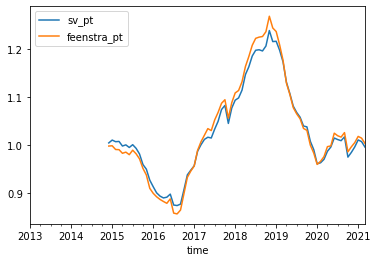

In [1021]:
ptest[["sv_pt", "feenstra_pt"]].rolling(12).mean().plot()

<AxesSubplot:xlabel='time'>

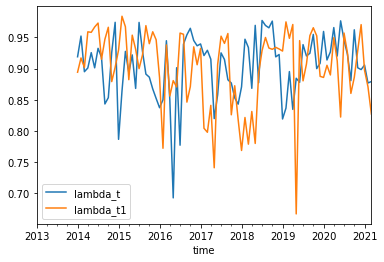

In [1022]:
ptest[["lambda_t", "lambda_t1"]].plot()

In [938]:
ptest[["lambda_t", "lambda_t1", "feenstra_adj"]].loc["2016":"2020"]

,lambda_t,lambda_t1,feenstra_adj
time,,,
2016-01-01,0.475336,0.471552,1.008026
2016-02-01,0.462994,0.443904,1.043007
2016-03-01,0.478668,0.424262,1.128236
2016-04-01,0.447409,0.403626,1.108474
2016-05-01,0.471375,0.433006,1.088612
2016-06-01,0.451760,0.482870,0.935573
2016-07-01,0.449561,0.451818,0.995006
2016-08-01,0.411260,0.451901,0.910066
2016-09-01,0.452655,0.467847,0.967527


The stuff in 2017 says, with lambda_t and lambda_t1 < 1. So that says the common set is much lower than total expenditures. This makes sense becuase a change in codes in 2017, shrinks the common set. And then the expenditures on the common set are much smaller than the total in each period.

The next question is why is lambda_t > lambda_t1, so that the ratio is greater than 1. If total expenditures are the same in both periods. This means that expenditures in the common set > in t vs t1. This is like demand is moving towards those products that remaind...

In [630]:
df.sort_index()

CON_VAL_MO CTY_NAME  \
time       I_COMMODITY                        
2013-01-01 4401220000      15215.0   CANADA   
           4401310000    2844669.0   CANADA   
           4401392000      13521.0   CANADA   
           4401394010      87861.0   CANADA   
           4401394020    2633300.0   CANADA   
...                            ...      ...   
2021-03-01 4421998800      11841.0   CANADA   
           4421999300     106460.0   CANADA   
           4421999400    2678252.0   CANADA   
           4421999730    2466869.0   CANADA   
           4421999780   16401612.0   CANADA   

                                                        I_COMMODITY_SDESC  \
time       I_COMMODITY                                                      
2013-01-01 4401220000           WOOD IN CHIPS OR PARTICLES, NONCONIFEROUS   
           4401310000                                        WOOD PELLETS   
           4401392000   ARTIFICIAL FIRE LOGS, COMPOSED OF WAX AND SAWDUST   
           4401394010                           SAWDUST, NOT AGGLOMERATED   
           4401394020           WOOD SHAVING, WHETHER OR NOT AGGLOMERATED   
...                                                                   ...   
2021-03-01 4421998800                               CANOE PADDLES OF WOOD   
           4421999300   THEATRICAL/BALLET SCENERY AND PROPERTIES, OF WOOD   
           4421999400                            EDGE-GLUED LUMBER, NESOI   
           4421999730                              BURIAL CASKETS OF WOOD   
           4421999780                             ARTICLES OF WOOD, NESOI   

                        CON_QY1_MO UNIT_QY1 COMM_LVL CTY_CODE       price  
time       I_COMMODITY                                                     
2013-01-01 4401220000         20.0        T     HS10     1220  760.750000  
           4401310000   13563256.0       KG     HS10     1220    0.209733  
           4401392000      39634.0       KG     HS10     1220    0.341146  
           4401394010     275408.0       KG     HS10     1220    0.319021  
           4401394020   12531458.0       KG     HS10     1220    0.210135  
...                            ...      ...      ...      ...         ...  
2021-03-01 4421998800        149.0       NO     HS10     1220   79.469799  
           4421999300      19694.0       KG     HS10     1220    5.405707  
           4421999400       2884.0       M3     HS10     1220  928.658807  
           4421999730       3320.0       NO     HS10     1220  743.032831  
           4421999780   20370111.0       KG     HS10     1220    0.805180  

[23685 rows x 8 columns]